## STEP 1: PREPROCESSING

In [35]:
import pandas as pd
import numpy as np
import csv
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel


### Take the list of players for evaluation

In [3]:
df_raw = pd.read_csv(r"C:\Users\Hungdever\Desktop\My_study\EPL\data\results.csv")
df_etv = pd.read_csv(r"C:\Users\Hungdever\Desktop\My_study\EPL\data\EX4-p1-results-bertcos.csv")
print(f"Number of rows in df_raw: {df_raw.shape[0]}")
print(f"Number of rows in df_etv: {df_etv.shape[0]}")

Number of rows in df_raw: 494
Number of rows in df_etv: 303


### Combine filtered statistics data and ETV 

In [4]:
df_etv_selection = df_etv[['Player Name', 'ETV']]

df_merged = pd.merge(
    df_etv_selection,
    df_raw,
    left_on='Player Name',  
    right_on='player',      
    how='inner'
)

df_merged = df_merged.drop(columns=['player'])
cols = df_merged.columns.tolist()
cols.remove('ETV')
cols.append('ETV')
df_merged = df_merged[cols]
df_merged

,Player Name,team,Req_Nation,Req_Position,Req_Age,Pltime_matches_played,Pltime_starts,Pltime_minutes,Defen_Att,Defen_Blocks,...,Prog_PrgR,Shoot_Dist,Shoot_G/Sh,Shoot_SoT%,Shoot_SoT/90,per90_Ast,per90_Gls,per90_xG,per90_xGA,ETV
0,Aaron Ramsdale,Southampton,eng ENG,GK,26.0,27.0,27.0,2430.0,N/a,0.0,...,0.0,N/a,N/a,N/a,0.00,0.00,0.00,0.00,0.00,€18.7M
1,Aaron Wan-Bissaka,West Ham United,eng ENG,DF,27.0,33.0,32.0,2884.0,N/a,32.0,...,150.0,15.1,0.13,31.3,0.16,0.09,0.06,0.04,0.10,€26.9M
2,Abdoulaye Doucouré,Everton,ml MLI,MF,32.0,30.0,29.0,2425.0,N/a,30.0,...,91.0,13.8,0.1,31.0,0.33,0.04,0.11,0.14,0.09,€5.8M
3,Adam Armstrong,Southampton,eng ENG,"FW,MF",28.0,20.0,15.0,1248.0,N/a,6.0,...,79.0,16.6,0.08,28.0,0.50,0.14,0.14,0.24,0.09,€24.4M
4,Adam Smith,Bournemouth,eng ENG,DF,34.0,22.0,17.0,1409.0,N/a,12.0,...,31.0,16.9,0.0,0.0,0.00,0.00,0.00,0.04,0.02,€1.5M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,Youri Tielemans,Aston Villa,be BEL,MF,28.0,35.0,35.0,2997.0,N/a,37.0,...,48.0,20.3,0.08,31.6,0.36,0.21,0.09,0.09,0.21,€41.5M
301,Yukinari Sugawara,Southampton,jp JPN,"DF,MF",24.0,29.0,15.0,1467.0,N/a,17.0,...,76.0,19.2,0.08,38.5,0.31,0.06,0.06,0.03,0.14,€15.7M
302,Yves Bissouma,Tottenham Hotspur,ml MLI,MF,28.0,25.0,16.0,1300.0,N/a,9.0,...,3.0,23.4,0.18,36.4,0.28,0.00,0.14,0.04,0.02,€29.8M
303,Álex Moreno,Nottingham Forest,es ESP,"DF,MF",31.0,15.0,11.0,955.0,N/a,11.0,...,34.0,23.7,0.0,0.0,0.00,0.09,0.00,0.02,0.12,€11M


### Clean the target variable (ETV)

In [5]:
def parse_etv(etv_str):
    if pd.isna(etv_str) or etv_str == '': 
        return np.nan
    etv_str = str(etv_str).replace('€', '') # Remove euro sign at the head of transfer values
    value = np.nan
    if 'M' in etv_str: 
        value = float(etv_str.replace('M', ''))
    elif 'k' in etv_str: 
        value = float(etv_str.replace('k', '')) / 1000.0
    elif 'B' in etv_str: 
        value = float(etv_str.replace('B', '')) * 1000.0
    else:
        try: value = float(etv_str) / 1_000_000.0
        except ValueError: value = np.nan
    return value

df_merged['ETV_numeric'] = df_merged['ETV'].apply(parse_etv)

# Remove rows with invalid ETV values after conversion
initial_rows = df_merged.shape[0]
df_merged.dropna(subset=['ETV_numeric'], inplace=True)
rows_dropped_etv = initial_rows - df_merged.shape[0]
if rows_dropped_etv > 0:
    print(f"Removed {rows_dropped_etv} rows due to missing or invalid ETV values after processing.")

if df_merged.shape[0] == 0:
    print("Error: No data remaining after processing ETV.")

### Define Features (X) and Target (y)

In [6]:

cols_to_drop_final = ['Player Name', 'ETV', 'ETV_numeric']
cols_exist_to_drop = [col for col in cols_to_drop_final if col in df_merged.columns]
X = df_merged.drop(columns=cols_exist_to_drop)
y = df_merged['ETV_numeric']

print(f"Final number of data samples for training/testing: {X.shape[0]}")
print(f"Initial number of features: {X.shape[1]}")

Final number of data samples for training/testing: 305
Initial number of features: 77


In [7]:
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (305, 77)
Shape of y: (305,)


In [12]:
X

,team,Req_Nation,Req_Position,Req_Age,Pltime_matches_played,Pltime_starts,Pltime_minutes,Defen_Att,Defen_Blocks,Defen_Int,...,Prog_PrgP,Prog_PrgR,Shoot_Dist,Shoot_G/Sh,Shoot_SoT%,Shoot_SoT/90,per90_Ast,per90_Gls,per90_xG,per90_xGA
0,Southampton,eng ENG,GK,26.0,27.0,27.0,2430.0,N/a,0.0,2.0,...,0.0,0.0,N/a,N/a,N/a,0.00,0.00,0.00,0.00,0.00
1,West Ham United,eng ENG,DF,27.0,33.0,32.0,2884.0,N/a,32.0,60.0,...,132.0,150.0,15.1,0.13,31.3,0.16,0.09,0.06,0.04,0.10
2,Everton,ml MLI,MF,32.0,30.0,29.0,2425.0,N/a,30.0,9.0,...,78.0,91.0,13.8,0.1,31.0,0.33,0.04,0.11,0.14,0.09
3,Southampton,eng ENG,"FW,MF",28.0,20.0,15.0,1248.0,N/a,6.0,3.0,...,21.0,79.0,16.6,0.08,28.0,0.50,0.14,0.14,0.24,0.09
4,Bournemouth,eng ENG,DF,34.0,22.0,17.0,1409.0,N/a,12.0,14.0,...,40.0,31.0,16.9,0.0,0.0,0.00,0.00,0.00,0.04,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,Aston Villa,be BEL,MF,28.0,35.0,35.0,2997.0,N/a,37.0,22.0,...,234.0,48.0,20.3,0.08,31.6,0.36,0.21,0.09,0.09,0.21
301,Southampton,jp JPN,"DF,MF",24.0,29.0,15.0,1467.0,N/a,17.0,10.0,...,68.0,76.0,19.2,0.08,38.5,0.31,0.06,0.06,0.03,0.14
302,Tottenham Hotspur,ml MLI,MF,28.0,25.0,16.0,1300.0,N/a,9.0,16.0,...,72.0,3.0,23.4,0.18,36.4,0.28,0.00,0.14,0.04,0.02
303,Nottingham Forest,es ESP,"DF,MF",31.0,15.0,11.0,955.0,N/a,11.0,15.0,...,34.0,34.0,23.7,0.0,0.0,0.00,0.09,0.00,0.02,0.12


In [13]:
y

0      18.7
1      26.9
2       5.8
3      24.4
4       1.5
       ... 
300    41.5
301    15.7
302    29.8
303    11.0
304     0.9
Name: ETV_numeric, Length: 305, dtype: float64

### Identify Column Types and Build Preprocessing Pipeline 


In [ ]:
num_ft_init = X.select_dtypes(include=np.number).columns.tolist()
categorical_ft_init = X.select_dtypes(exclude=np.number).columns.tolist()
potential_num_obj = []
for col in categorical_ft_init:
    try:
        subset = X[col].dropna()
        if not subset.empty:
            pd.to_numeric(subset.sample(min(5, len(subset))), errors='raise')
            potential_num_obj.append(col)
    except (ValueError, TypeError):
        pass
    except Exception as e:
        print(f"Error checking column '{col}': {e}")

# Finalize the feature lists
num_ft = sorted(list(set(num_ft_init + potential_num_obj)))
categorical_ft = sorted([col for col in categorical_ft_init if col not in potential_num_obj])

print(f"\nNumeric features ({len(num_ft)}): {num_ft[:5]}...")
print(f"Categorical features ({len(categorical_ft)}): {categorical_ft}")


Numeric features (66): ['Defen_Blocks', 'Defen_Int', 'Defen_Pass', 'Defen_Sh', 'Defen_Tkl']...
Categorical features (11): ['Defen_Att', 'Defen_Lost', 'GK_CS%', 'GK_GA90', 'GK_PK_Save%', 'GK_Save%', 'Req_Nation', 'Req_Position', 'Shoot_G/Sh', 'Shoot_SoT%', 'team']


In [18]:
numeric_transformer = Pipeline(steps=[
    ('to_numeric', FunctionTransformer(lambda df: df.apply(pd.to_numeric, errors='coerce'), validate=False)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ft),
        ('cat', categorical_transformer, categorical_ft)
    ],
    remainder='passthrough' # Keep other columns not specified
)

print("\n--- Step 1 Completed ---")
print("Loaded, filtered, merged data, cleaned ETV, identified X, y, and built the preprocessing pipeline.")


--- Step 1 Completed ---
Loaded, filtered, merged data, cleaned ETV, identified X, y, and built the preprocessing pipeline.


## STEP 2: Choosing features

In [46]:
print("\n--- Starting Step 2: Feature Selection ---")

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 


--- Starting Step 2: Feature Selection ---


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("Data preprocessing complete.")

Data preprocessing complete.


In [ ]:
# Get feature names 
try:
    onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = onehot_encoder.get_feature_names_out(categorical_ft) 
    processed_feature_names = num_ft + list(cat_feature_names) 

    X_train_processed_df = pd.DataFrame(X_train_processed, columns=processed_feature_names, index=X_train.index)
    X_test_processed_df = pd.DataFrame(X_test_processed, columns=processed_feature_names, index=X_test.index)

    print(f"Number of features after preprocessing: {len(processed_feature_names)}")

except Exception as e:
    print(f"Error getting feature names after processing: {e}")
    processed_feature_names = [] 

Number of features after preprocessing: 349


Training random forest to calculate feature importance...

Top 20 most important features:
              Feature  Importance
0             Req_Age    0.165900
1            per90_xG    0.075742
2   Req_Nation_no NOR    0.038132
3            Poss_CPA    0.038114
4           Pass_PrgP    0.028119
5              Exp_xG    0.027610
6          Perf_goals    0.026019
7           per90_Gls    0.024206
8            Pass_PPA    0.023482
9        Shoot_SoT/90    0.022288
10           Pass_1/3    0.020732
11          Prog_PrgC    0.020554
12    Pass_cpt_medium    0.020473
13          per90_Ast    0.019885
14          Prog_PrgP    0.019877
15            GnS_SCA    0.017833
16         Defen_TklW    0.016082
17            GnS_GCA    0.015896
18          Pass_Cmp%    0.014959
19          Poss_PrgC    0.012739


C:\Users\Hungdever\AppData\Local\Temp\ipykernel_1312\3312753773.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')


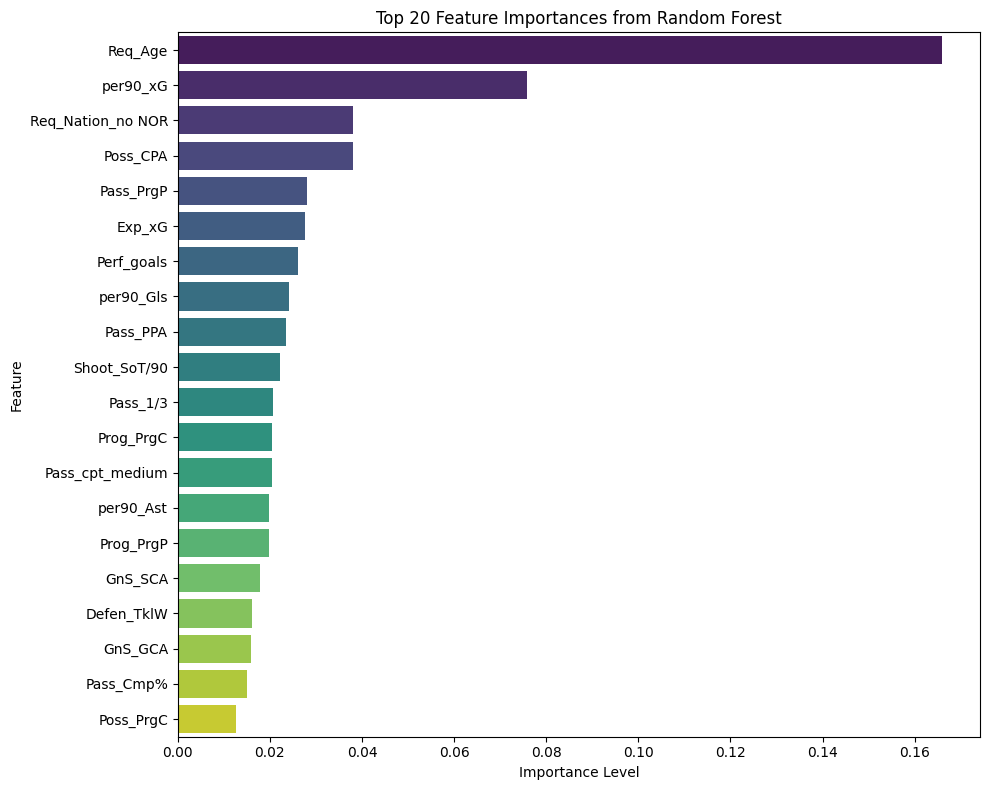

Created Top 20 Feature Importances chart (displays if using plt.show()).
Selecting features based on the trained Random Forest model...


c:\Users\Hungdever\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\Hungdever\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(



Number of features after selection (median threshold): 175
Selected features (example): ['Defen_Blocks', 'Defen_Int', 'Defen_Pass', 'Defen_Sh', 'Defen_Tkl', 'Defen_TklW', 'Exp_xAG', 'Exp_xG', 'GnS_GCA', 'GnS_GCA90']...

--- Step 2 Completed ---


In [ ]:
# Calculate feature importance using Random Forest
if processed_feature_names:

    rf_for_importance = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_for_importance.fit(X_train_processed_df, y_train)

    # Get importance scores
    importances = rf_for_importance.feature_importances_

    # Create a DataFrame for easy viewing and sorting
    feature_importance_df = pd.DataFrame({'Feature': processed_feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    print("\nTop 20 most important features:")
    print(feature_importance_df.head(20))

    # Visualize the top important features
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')
    plt.title('Top 20 Feature Importances from Random Forest')
    plt.xlabel('Importance Level')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    print("Created Top 20 Feature Importances chart (displays if using plt.show()).")

    print("Selecting features based on the trained Random Forest model...")
    selector = SelectFromModel(rf_for_importance, prefit=True, threshold='median')

    # Apply the selector to get data containing only the selected features
    X_train_selected = selector.transform(X_train_processed_df)
    X_test_selected = selector.transform(X_test_processed_df)

    # Get the names of the selected features
    selected_mask = selector.get_support()
    selected_features = X_train_processed_df.columns[selected_mask].tolist()

    print(f"\nNumber of features after selection (median threshold): {len(selected_features)}")
    print(f"Selected features (ex): {selected_features[:10]}...") # Print the first 10 features

else:
    print("Cannot perform Feature Importance calculation because an error in retrieving feature names.")
    X_train_selected = X_train_processed
    X_test_selected = X_test_processed
    selected_features = processed_feature_names # Can be empty
    print("Will use all preprocessed features for the next step.")


print("\n--- Step 2 Completed ---")

## STEP 3: CHOOSING MODEL AND TRAINING

In [38]:
print("\n--- Starting Step 3: Model Selection and Training ---")

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

models = {
    'Ridge': Ridge(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

print(f"Models to be evaluated: {list(models.keys())}")

results_rmse = {}
results_mae = {}
cv_folds = 5

print(f"\nPerforming {cv_folds}-Fold Cross-Validation...")

for name, model in models.items():
    print(f"Evaluating model: {name}")
    rmse_cv_scores = cross_val_score(model, X_train_selected, y_train,
                                     scoring='neg_root_mean_squared_error', cv=cv_folds, n_jobs=-1)
    results_rmse[name] = -rmse_cv_scores

    mae_cv_scores = cross_val_score(model, X_train_selected, y_train,
                                    scoring='neg_mean_absolute_error', cv=cv_folds, n_jobs=-1)
    results_mae[name] = -mae_cv_scores

print("\n--- Cross-Validation Results ---")
print("Average RMSE (lower is better):")
for name, scores in results_rmse.items():
    print(f"- {name}: {scores.mean():.4f} (Std: {scores.std():.4f})")

print("\nAverage MAE (lower is better):")
for name, scores in results_mae.items():
    print(f"- {name}: {scores.mean():.4f} (Std: {scores.std():.4f})")

best_model_name = min(results_rmse, key=lambda k: results_rmse[k].mean())
print(f"\nBest model based on average RMSE from CV: {best_model_name}")

best_model = models[best_model_name]

print(f"Training model '{best_model_name}' on the entire selected training data...")
try:
    best_model.fit(X_train_selected, y_train)
    print("Training complete.")
except Exception as e:
    print(f"Error during final model training: {e}")
    exit()

print("\n--- Step 3 Completed ---")


--- Starting Step 3: Model Selection and Training ---
Models to be evaluated: ['Ridge', 'RandomForest', 'GradientBoosting']

Performing 5-Fold Cross-Validation...
Evaluating model: Ridge
Evaluating model: RandomForest
Evaluating model: GradientBoosting

--- Cross-Validation Results ---
Average RMSE (lower is better):
- Ridge: 21.5026 (Std: 2.3501)
- RandomForest: 18.2381 (Std: 3.1768)
- GradientBoosting: 17.9799 (Std: 3.5360)

Average MAE (lower is better):
- Ridge: 14.7836 (Std: 1.2525)
- RandomForest: 12.4210 (Std: 1.5171)
- GradientBoosting: 11.6845 (Std: 1.5171)

Best model based on average RMSE from CV: GradientBoosting
Training model 'GradientBoosting' on the entire selected training data...
Training complete.

--- Step 3 Completed ---



--- Starting Step 4: Evaluate Model on Test Set ---
Using model 'GradientBoosting' to predict on 61 test samples:
Prediction complete.

--- Evaluation Results on Test Set ---
RMSE: 15.2200 (Million €)
-> Average prediction error (according to RMSE) is approximately 15.22 million Euro.
MAE: 11.3339 (Million €)
-> Average absolute error is 11.33 million Euro.
R-squared (R2): 0.6712
-> The model explains approximately 67.12% of the variance in player value.
Creating a plot to compare actual and predicted values...
Plot has been created (displays if using plt.show()).
Residual distribution plot has been created (displays if using plt.show()).

--- Step 4 Completed ---
Model has been evaluated on the test set and results visualized.


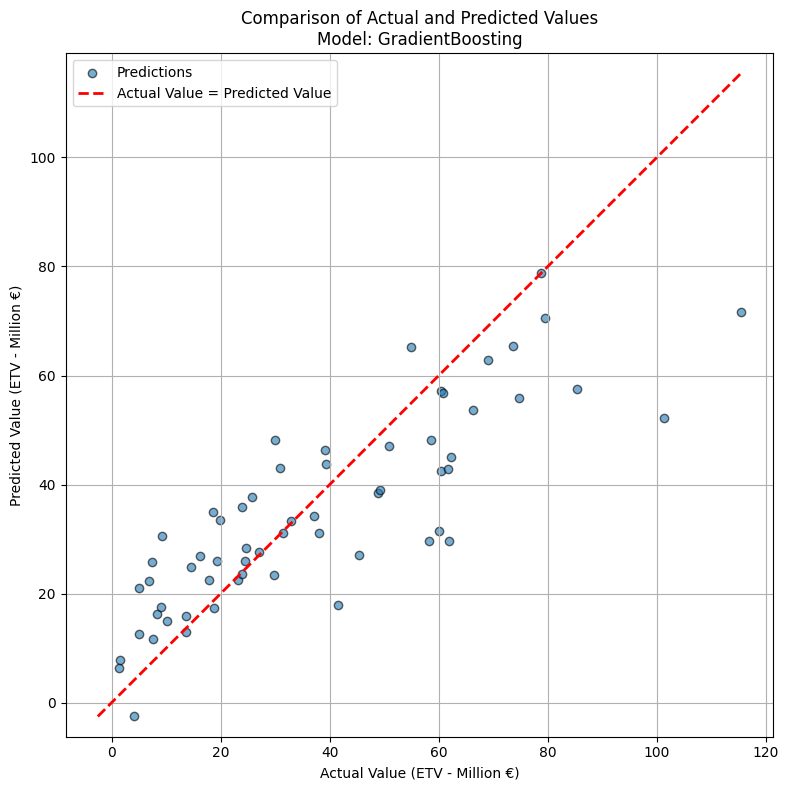

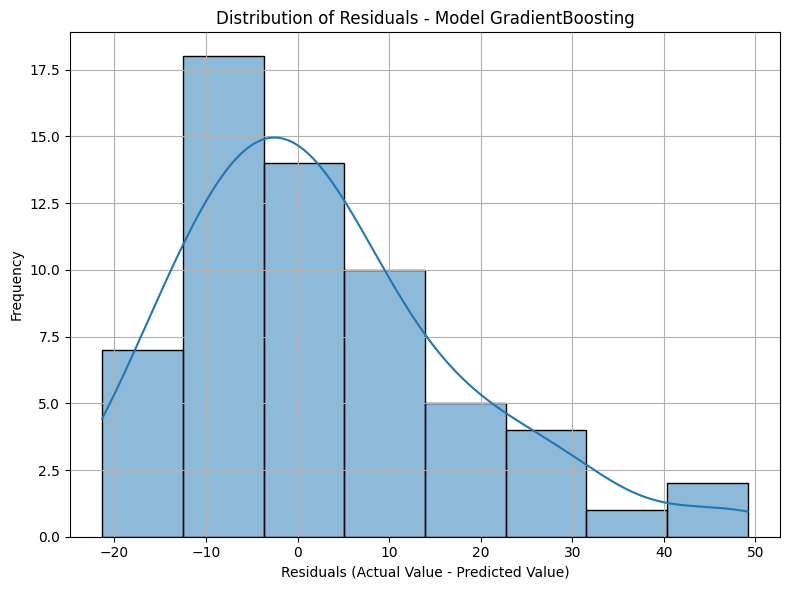

In [ ]:
print("\n--- Starting Step 4: Evaluate Model on Test Set ---")

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print(f"Using model '{best_model_name}' to predict on {X_test_selected.shape[0]} test samples:")
try:
    y_pred = best_model.predict(X_test_selected)
    print("Prediction complete.")
except NameError:
    print("Error: Variable 'best_model' or 'X_test_selected' is not defined.")
    exit()
except Exception as e:
    print(f"Error during prediction: {e}")
    exit()

if 'y_test' not in locals() or 'y_pred' not in locals() or len(y_test) != len(y_pred):
    print("Error: Cannot calculate metrics.")
    exit()

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print("\n--- Evaluation Results on Test Set ---")
print(f"RMSE: {rmse_test:.4f} (Million €)")
print(f"-> Average prediction error (according to RMSE) is approximately {rmse_test:.2f} million Euro.")
print(f"MAE: {mae_test:.4f} (Million €)")
print(f"-> Average absolute error is {mae_test:.2f} million Euro.")
print(f"R-squared (R2): {r2_test:.4f}")
print(f"-> The model explains approximately {r2_test*100:.2f}% of the variance in player value.")

print("Creating a plot to compare actual and predicted values...")
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', label='Predictions')
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], '--r', linewidth=2, label='Actual Value = Predicted Value')
plt.xlabel("Actual Value (ETV - Million €)")
plt.ylabel("Predicted Value (ETV - Million €)")
plt.title(f"Comparison of Actual and Predicted Values\nModel: {best_model_name}")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
print("Plot has been created.")

residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title(f'Distribution of Residuals - Model {best_model_name}')
plt.xlabel('Residuals (Actual Value - Predicted Value)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
print("Residual distribution plot has been created.")

print("\n--- Step 4 Completed ---")
print("Model has been evaluated on the test set and results visualized.")